In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-whitegrid')

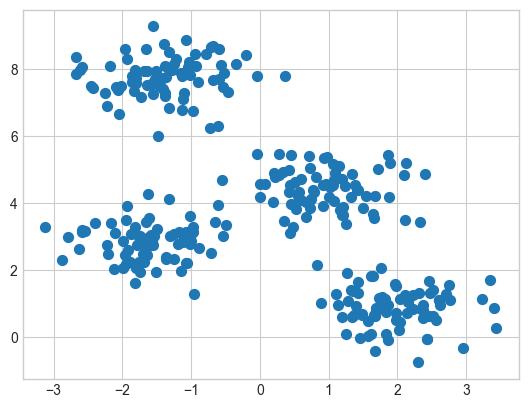

In [2]:
# 建立一個沒有標籤的資料集
from sklearn.datasets import make_blobs
X, y_true = make_blobs(n_samples=300, centers=4,
                       cluster_std=0.60, random_state=0)
plt.scatter(X[:, 0], X[:, 1], s=50);

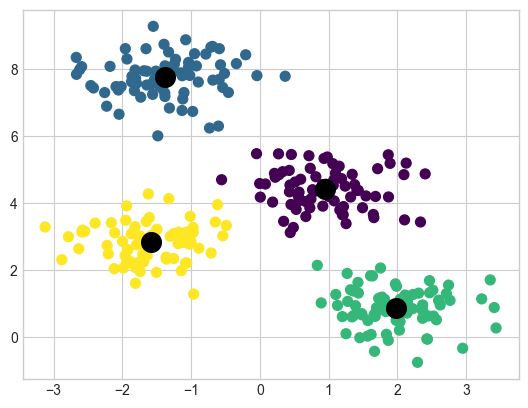

In [3]:
# 使用 K means 分群
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=4)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)

# 視覺化結果
plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=50, cmap='viridis')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200);

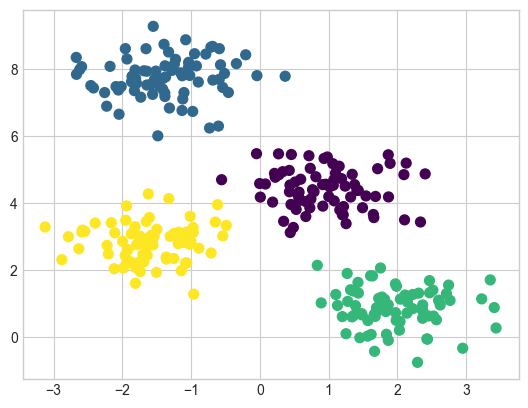

In [5]:
# k 平均法甚至可以用幾行程式碼實作
from sklearn.metrics import pairwise_distances_argmin

def find_clusters(X, n_clusters, rseed=2):
    # 1. 隨機選取群組
    rng = np.random.RandomState(rseed)
    i = rng.permutation(X.shape[0])[:n_clusters]
    centers = X[i]

    while True:
        # 2a. 基於最近的中心點設定標籤
        labels = pairwise_distances_argmin(X, centers)
        
        # 2b. 從點的平均找出新的中心
        new_centers = np.array([X[labels == i].mean(0)
                                for i in range(n_clusters)])
        
        # 2c. 檢查是否收斂
        if np.all(centers == new_centers):
            break
        centers = new_centers

    return centers, labels

centers, labels = find_clusters(X, 4)
plt.scatter(X[:, 0], X[:, 1], c=labels,
            s=50, cmap='viridis'); 

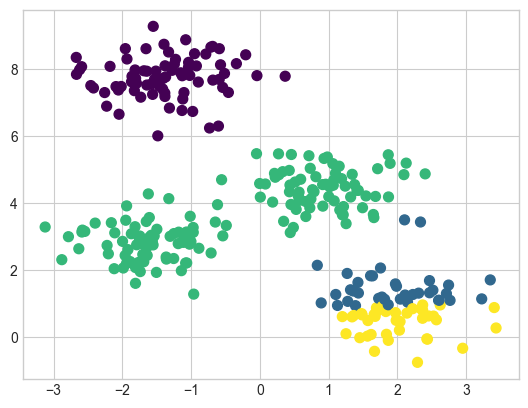

In [ ]:
# 不好的起始位置
centers, labels = find_clusters(X, 4, rseed=0)
plt.scatter(X[:, 0], X[:, 1], c=labels,
            s=50, cmap='viridis');

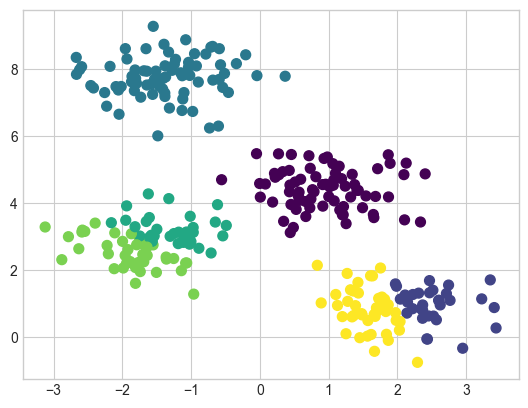

In [8]:
# 設定分群數為6 也會有結果
labels = KMeans(6, random_state=0).fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels,
            s=50, cmap='viridis');

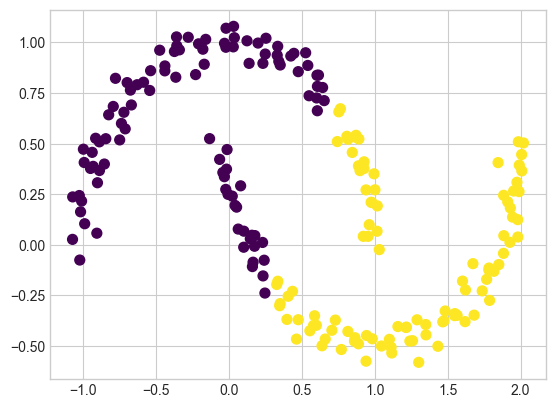

In [9]:
# 非線性邊界效果很差
from sklearn.datasets import make_moons
X, y = make_moons(200, noise=.05, random_state=0)

labels = KMeans(2, random_state=0).fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels,
            s=50, cmap='viridis');

c:\Users\coffi\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


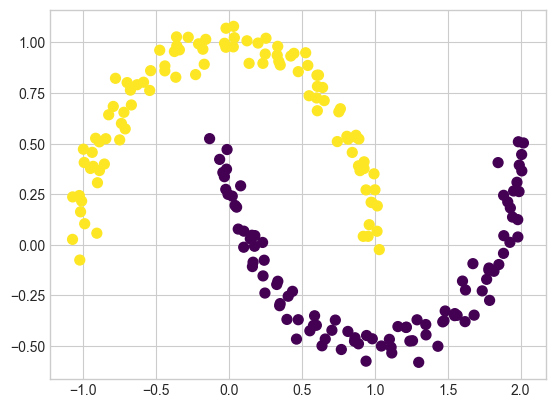

In [10]:
# 使用核化版本的K Means
from sklearn.cluster import SpectralClustering
model = SpectralClustering(n_clusters=2,
                           affinity='nearest_neighbors',
                           assign_labels='kmeans')
labels = model.fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels,
            s=50, cmap='viridis');

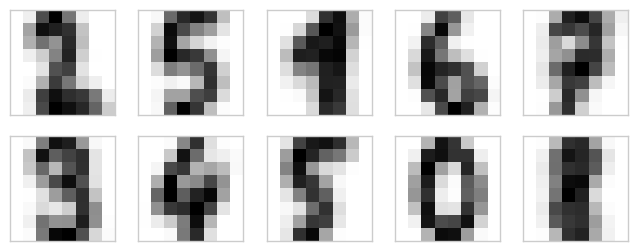

In [16]:
# 載入手寫數字資料集
from sklearn.datasets import load_digits
digits = load_digits()

# 用K Means 分10個數字
kmeans = KMeans(n_clusters=10, random_state=0)
clusters = kmeans.fit_predict(digits.data)

# 檢視一下結果
fig, ax = plt.subplots(2, 5, figsize=(8, 3))
centers = kmeans.cluster_centers_.reshape(10, 8, 8)
for axi, center in zip(ax.flat, centers):
    axi.set(xticks=[], yticks=[])
    axi.imshow(center, interpolation='nearest', cmap=plt.cm.binary)

In [17]:
# 將實際標籤與分群結果配對
from scipy.stats import mode

labels = np.zeros_like(clusters)
for i in range(10):
    mask = (clusters == i)
    labels[mask] = mode(digits.target[mask])[0]

# 檢查準確率
from sklearn.metrics import accuracy_score
accuracy_score(digits.target, labels)

0.7440178074568725

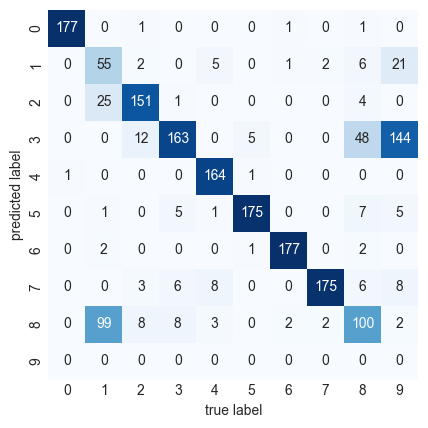

In [15]:
# 混淆矩陣
from sklearn.metrics import confusion_matrix
import seaborn as sns
mat = confusion_matrix(digits.target, labels)
sns.heatmap(mat.T, square=True, annot=True, fmt='d',
            cbar=False, cmap='Blues',
            xticklabels=digits.target_names,
            yticklabels=digits.target_names)
plt.xlabel('true label')
plt.ylabel('predicted label');

In [18]:
# 先使用 t-SNE 降維
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, init='random',
            learning_rate='auto', random_state=0)
digits_proj = tsne.fit_transform(digits.data)

# 再計算群組
kmeans = KMeans(n_clusters=10, random_state=0)
clusters = kmeans.fit_predict(digits_proj)

# 排列標籤
labels = np.zeros_like(clusters)
for i in range(10):
    mask = (clusters == i)
    labels[mask] = mode(digits.target[mask])[0]

# 正確率
accuracy_score(digits.target, labels)

0.9410127991096272

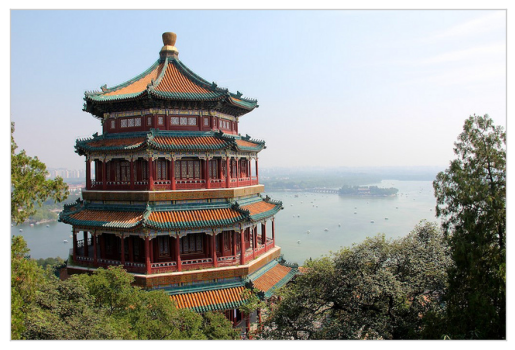

In [20]:
# 載入高畫質照片
from sklearn.datasets import load_sample_image
china = load_sample_image('china.jpg')
ax = plt.axes(xticks=[], yticks=[])
ax.imshow(china);

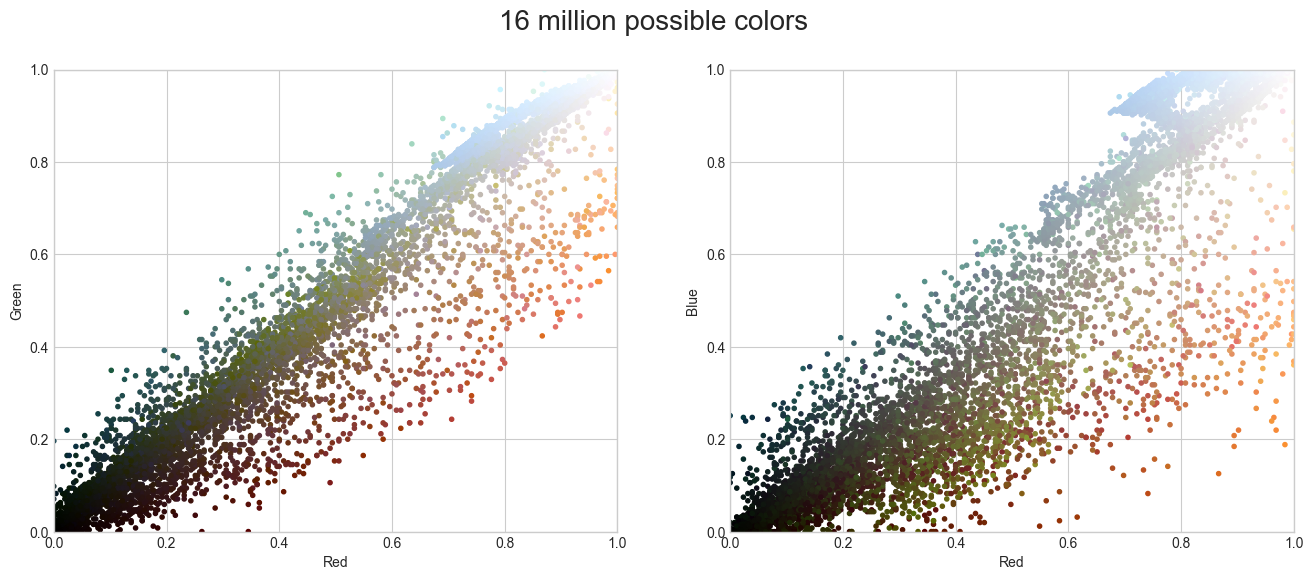

In [23]:
# 將 RGB 縮到 0-1之間
data = china / 255.0
data = data.reshape(-1, 3)

# 視覺化只用 10,000 個像素點
def plot_pixels(data, title, colors=None, N=10000):
    if colors is None:
        colors = data
    
    rng = np.random.default_rng(0)

    i = rng.permutation(data.shape[0])[:N]
    colors = colors[i]
    R, G, B = data[i].T

    fig, ax = plt.subplots(1, 2, figsize=(16, 6))
    ax[0].scatter(R, G, color=colors, marker='.')
    ax[0].set(xlabel='Red', ylabel='Green', xlim=(0, 1), ylim=(0, 1))

    ax[1].scatter(R, B, color=colors, marker='.')
    ax[1].set(xlabel='Red', ylabel='Blue', xlim=(0, 1), ylim=(0, 1))

    fig.suptitle(title, size=20)

plot_pixels(data, title='16 million possible colors')

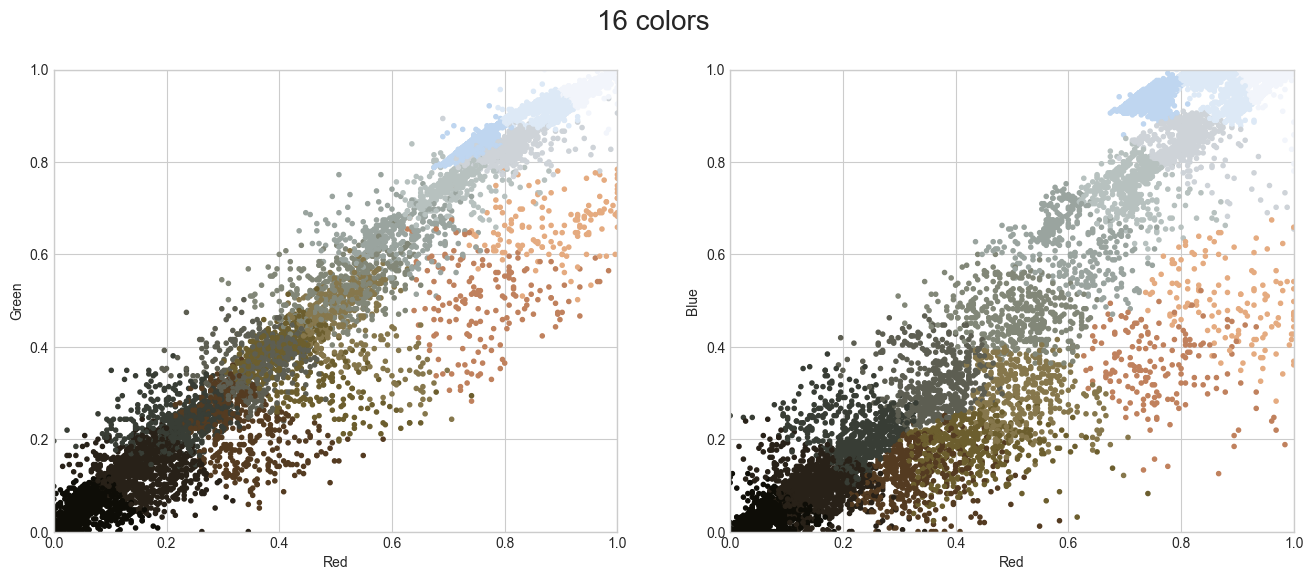

In [ ]:
# 使用mini batch K Means 處理大量像素資料
from sklearn.cluster import MiniBatchKMeans
kmeans = MiniBatchKMeans(16)
kmeans.fit(data)
new_colors = kmeans.cluster_centers_[kmeans.predict(data)]

plot_pixels(data, colors=new_colors,
            title = '16 colors')

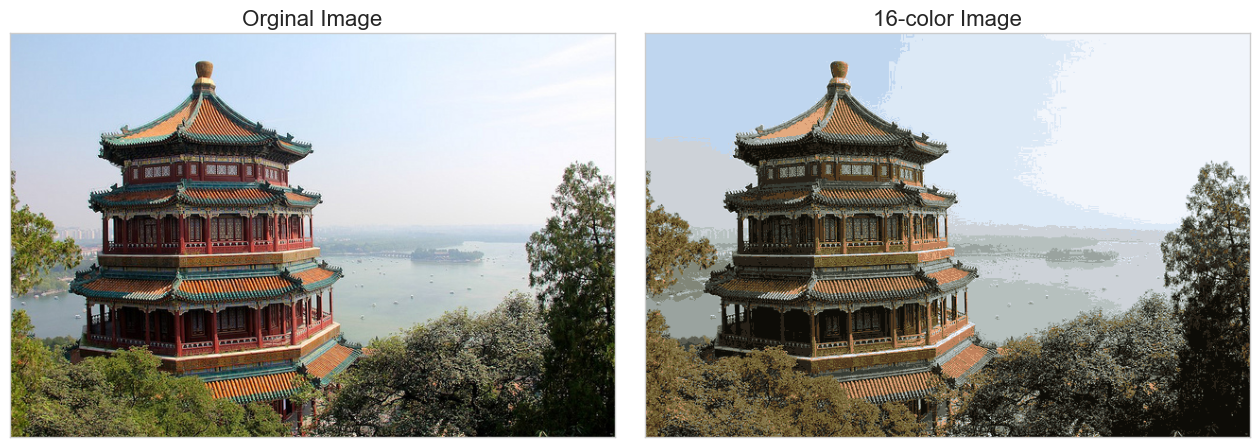

In [30]:
# 重新上色
china_recolored = new_colors.reshape(china.shape)

fig, ax = plt.subplots(1, 2, figsize=(16, 6),
                        subplot_kw=dict(xticks=[], yticks=[]))
fig.subplots_adjust(wspace=0.05)
ax[0].imshow(china)
ax[0].set_title('Orginal Image', size=16)
ax[1].imshow(china_recolored)
ax[1].set_title('16-color Image', size=16);